In [1]:
import pandas as pd
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [ ]:
import scanpy as sc
import random
import string
import subprocess
import anndata as an
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import warnings
from collections import Counter
from google.cloud import storage
import re
import gseapy as gp
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from anndata import AnnData
from itertools import chain
from scipy import sparse

%matplotlib inline
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
from py_pcha import PCHA

In [ ]:
readRDS = robjects.r['readRDS']
meta = readRDS('CCLE_metadata.RDS')
meta = pandas2ri.rpy2py_dataframe(meta)

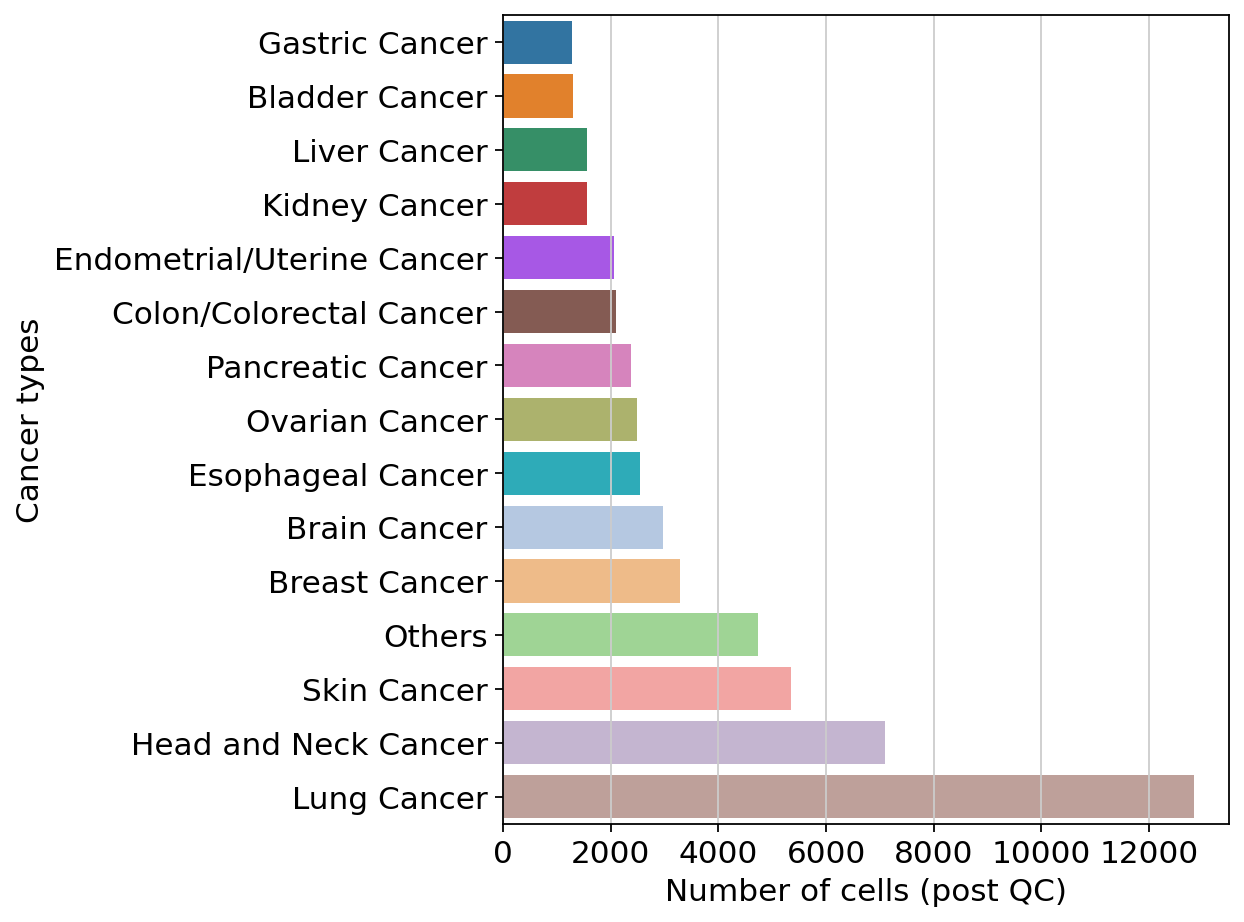

In [53]:
m = meta.groupby(by = "cancer_type_trunc").sum().sort_values(by = "n_cells").reset_index()

fig ,ax = plt.subplots(figsize = (8,6))
sns.barplot(data = m , y= "cancer_type_trunc", x ="n_cells")
plt.xlabel("Number of cells (post QC)")
plt.ylabel("Cancer types")
plt.tight_layout()
plt.show()
fig.savefig("meta.png")

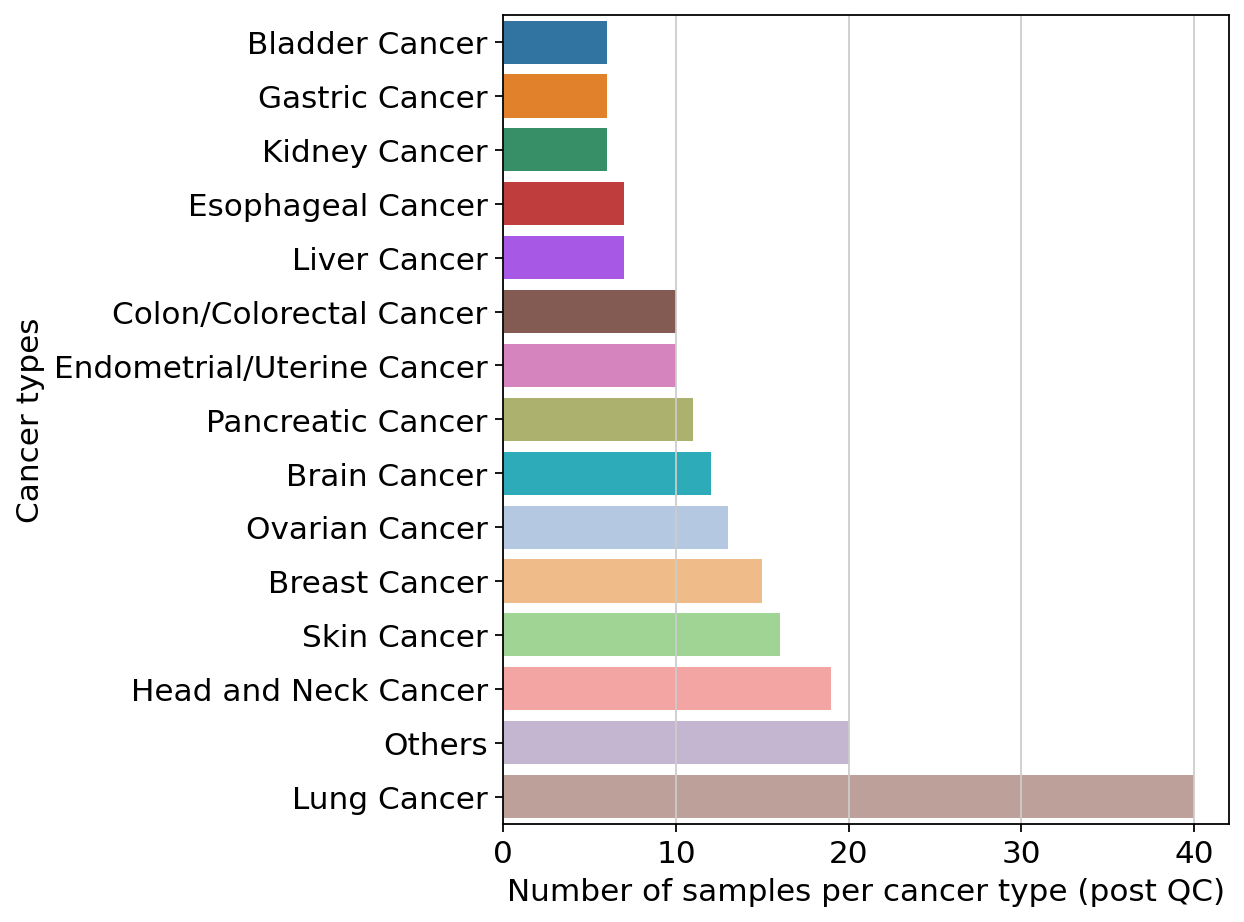

In [54]:
m = meta.groupby(by = "cancer_type_trunc").count().sort_values(by = "n_cells").reset_index()

fig ,ax = plt.subplots(figsize=(8,6))
sns.barplot(data = m , y= "cancer_type_trunc", x ="n_cells")
plt.xlabel("Number of samples per cancer type (post QC)")
plt.ylabel("Cancer types")
plt.tight_layout()
plt.show()
fig.savefig("meta_cancer.png")

In [41]:
meta['log_cells']  = np.log10(meta['n_cells'])
meta = meta.sort_values(by = "n_cells")
meta['cancer_sort'] = pd.Categorical(meta['cancer_type_trunc'], 
                                     ordered=True, 
                                     categories=list(meta.groupby(by = "cancer_type_trunc").count().sort_values(by ='n_cells', ascending = True).index))


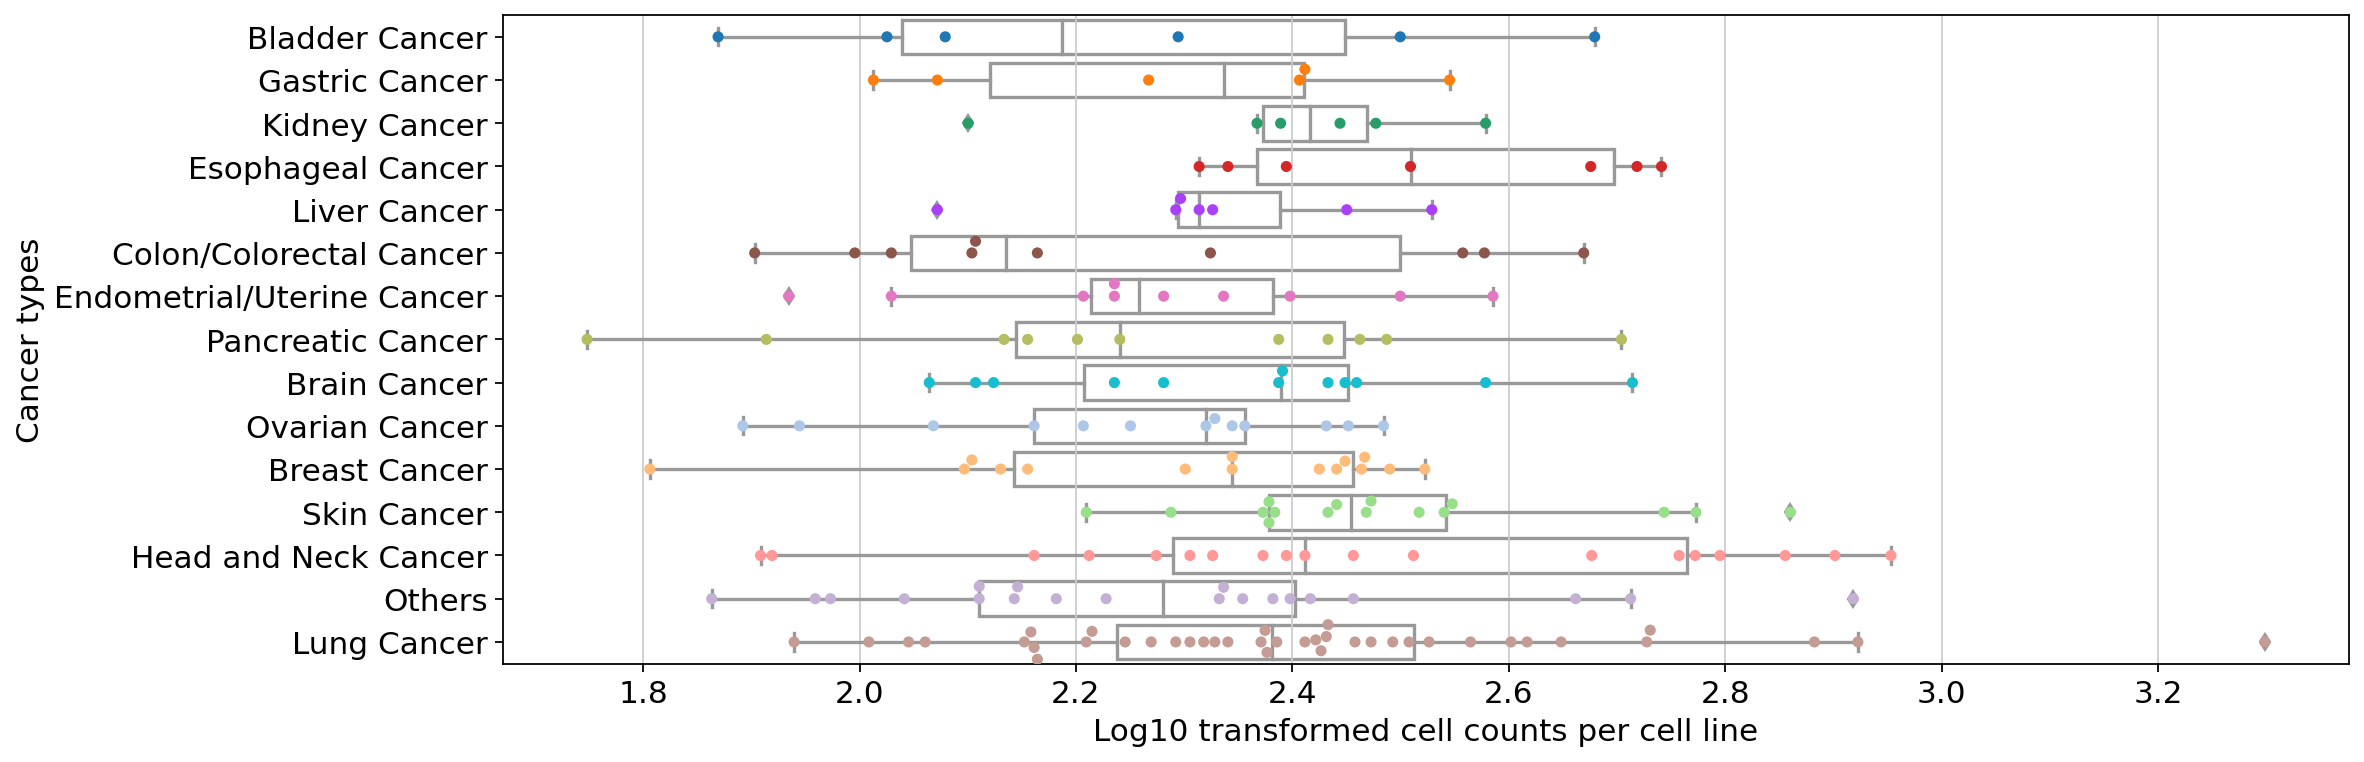

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data = meta, y = "cancer_sort", x= "log_cells", color = "white")
sns.swarmplot(data = meta, y= "cancer_sort", x = "log_cells")
plt.xlabel("Log10 transformed cell counts per cell line")
plt.ylabel("Cancer types")
plt.tight_layout()
plt.show()
fig.savefig("meta_cellcount.png")

In [55]:
df = readRDS('CCLE_scRNAseq_CPM.RDS')

In [61]:
##Copy number
copy_number = readRDS('CCLE_copynumber_bygene.RDS')
copy_number_df = pandas2ri.rpy2py_dataframe(copy_number)
copy_number_df = copy_number_df.T.reset_index()

In [74]:
merge_copy = meta.reset_index().merge(copy_number_df, left_on = "index", right_on = "index" )

In [75]:
merge_copy

,index,cancer_type,pool_id,n_cells,cancer_type_trunc,log_cells,cancer_sort,A1BG,NAT2,ADA,...,HNRPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,CASP8AP2,SCO2
0,HUPT4_PANCREAS,Pancreatic Cancer,16,56,Pancreatic Cancer,1.748188,Pancreatic Cancer,-0.0676,-0.6796,0.3882,...,-0.6491,0.4642,-0.6998,0.4115,0.0114,0.3058,-0.0282,-0.1186,0.4214,-0.1082
1,HDQP1_BREAST,Breast Cancer,16,64,Breast Cancer,1.806180,Breast Cancer,-0.1921,-0.3107,0.3751,...,-0.4469,0.4311,1.4977,0.0920,-0.2969,-1.0673,0.1962,-0.1722,0.3218,-0.2412
2,SNU1079_BILIARY_TRACT,Bile Duct Cancer,22,73,Others,1.863323,Others,0.1243,-0.3367,0.2559,...,-0.3651,0.1531,-0.3828,0.1797,-0.3873,-0.3858,0.1370,-0.4863,-0.3519,-0.4949
3,HT1197_URINARY_TRACT,Bladder Cancer,18,74,Bladder Cancer,1.869232,Bladder Cancer,0.1660,-0.0607,-0.1796,...,-0.0475,-0.0471,0.2765,0.1934,-0.6531,0.2982,0.2803,0.3986,-0.1095,0.3347
4,TOV112D_OVARY,Ovarian Cancer,6,78,Ovarian Cancer,1.892095,Ovarian Cancer,-0.2083,0.4592,-0.2153,...,-0.2296,-0.1034,-0.2036,0.2282,-0.1626,0.2682,0.3038,-0.1482,0.3662,-0.2284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,RERFLCAI_LUNG,Lung Cancer,15,763,Lung Cancer,2.882525,Lung Cancer,-0.1161,-0.0875,-0.1174,...,-0.1173,0.3347,1.3542,0.4014,-0.1140,-0.2082,-0.1462,-0.1221,-0.1446,-0.1751
184,HOS_BONE,Bone Cancer,15,829,Others,2.918555,Others,-0.1624,-0.0518,0.2918,...,-0.0706,-0.0457,0.5978,-0.0541,0.4116,0.2607,-0.0796,0.0066,-0.0668,0.0232
185,NCIH460_LUNG,Lung Cancer,6,837,Lung Cancer,2.922725,Lung Cancer,-0.3026,-0.2470,0.2409,...,-0.2603,0.3053,-0.2769,0.6683,0.0794,0.2992,-0.2671,-0.2896,-0.2594,-0.3291
186,SCC25_UPPER_AERODIGESTIVE_TRACT,Head and Neck Cancer,custom,898,Head and Neck Cancer,2.953276,Head and Neck Cancer,-0.1593,-0.7005,0.1589,...,-0.7065,-0.1264,-0.2397,0.2186,0.0954,0.4929,0.0422,0.1017,0.1518,-0.1105


In [76]:
gene_locus = readRDS('gene_locus.RDS')
gene_locus_df = pandas2ri.rpy2py_dataframe(gene_locus)

In [79]:
gene_locus_df.head()

,Gene.stable.ID,Chromosome.scaffold.name,Karyotype.band,HGNC.symbol,chr.arm
42,ENSG00000088766,20.0,p12.3,CRLS1,20p
43,ENSG00000086475,10.0,p13,SEPHS1,10p
44,ENSG00000174327,17.0,p13.1,SLC16A13,17p
45,ENSG00000227255,17.0,p12,CDRT15P2,17p
47,ENSG00000173597,4.0,q13.3,SULT1B1,4q


### Read in gene names 

In [56]:
gene_name = pd.read_csv("gene_name.txt", sep="\t", header = None)
gene_name_short = pd.read_csv("gene_name_short.txt", sep="\t", header = None)
gene_name.index = gene_name[0]
gene_name_short.index = gene_name_short[0]
gene_name.columns = ['gene']
gene_name_short.columns = ['gene']
gene_name.index.names = ['index']
gene_name_short.index.names = ['index']

In [83]:
intersection = list(set(gene_name_short['gene']).intersection(set(gene_name['gene'])).intersection(set(copy_number_df.columns[1:])) )

In [84]:
len(intersection)

16536

We profiled eight CCLE pools, along with one smaller custom pool that included head and neck squamous cell carcinoma (HNSCC) cell lines. (Results first line)

In [85]:
###get common genes bewteen the 8 CCLE pools and custom pool
common_gene,_, ind_long = np.intersect1d(intersection, gene_name['gene'], return_indices = True)
_,_, ind_short = np.intersect1d(intersection, gene_name_short['gene'], return_indices = True)

In [86]:
gene_name_short['gene'][ind_short]

index
A1BG            A1BG
A1BG-AS1    A1BG-AS1
A2M-AS1      A2M-AS1
A2ML1          A2ML1
A4GALT        A4GALT
              ...   
ZYG11A        ZYG11A
ZYG11B        ZYG11B
ZYX              ZYX
ZZEF1          ZZEF1
ZZZ3            ZZZ3
Name: gene, Length: 16536, dtype: object

In [87]:
gene_name['gene'][ind_long]

index
A1BG            A1BG
A1BG-AS1    A1BG-AS1
A2M-AS1      A2M-AS1
A2ML1          A2ML1
A4GALT        A4GALT
              ...   
ZYG11A        ZYG11A
ZYG11B        ZYG11B
ZYX              ZYX
ZZEF1          ZZEF1
ZZZ3            ZZZ3
Name: gene, Length: 16536, dtype: object

### Read in barcode names per cell sample

In [59]:
name_list = []
for name in meta.index[:-8]:
    obs = pd.read_csv(f"{name}_name.txt", sep="\t", header = None)
    name_list.append(obs[0])
unnest_name = list(chain.from_iterable(name_list))
name_df = pd.DataFrame(unnest_name, index = unnest_name, columns = ['Barcode'])
name_df.index.names = ['index']

In [60]:
short_name_list = []
for name in meta.index[-8:]:
    obs = pd.read_csv(f"{name}_name.txt", sep="\t", header = None)
    short_name_list.append(obs[0])
unnest_name = list(chain.from_iterable(short_name_list))
short_name_df = pd.DataFrame(unnest_name, index = unnest_name, columns = ['Barcode'])
short_name_df.index.names = ['index']

In [90]:
array_list = []
small_list = []
common_list = []

for d in df:
    if np.asarray(d).shape[0] != 28767:
        
        clean = np.asarray(d)
        clean = clean[ind_short,:]
        common_list.append(clean)
        #small_list.append(np.asarray(d))
        
    else:
        
        clean = np.asarray(d)
        clean = clean[ind_long,:]
        common_list.append(clean)
        #array_list.append(np.asarray(d))

In [93]:
common_stack = np.hstack(common_list)

In [94]:
common_stack.shape

(16536, 53513)

In [ ]:
sparse_X = sparse.csr_matrix(common_stack.T) 

In [ ]:
merge_cellline = name_df.append(short_name_df)

In [ ]:
merge_adata = AnnData(sparse_X)
merge_adata.var = common_gene
merge_adata.obs = merge_cellline

In [ ]:
merge_adata.write_h5ad("ccle_merge_cpm.h5ad")

In [97]:
# large_stack = np.hstack(array_list)
# small_stack = np.hstack(small_list)
# large_stack.shape, small_stack.shape

# common_large = large_stack[ind_long,:]
# common_short = small_stack[ind_short,:]
# common_large.shape, common_short.shape

###individual anndata

# large_adata = AnnData(large_stack.T)
# large_adata.var = gene_name
# large_adata.obs = name_df

# small_adata = AnnData(small_stack.T)
# small_adata.var = gene_name_short
# small_adata.obs = short_name_df

In [101]:
large_adata, small_adata

(AnnData object with n_obs × n_vars = 48879 × 28767
     obs: 'Barcode'
     var: 'gene',
 AnnData object with n_obs × n_vars = 4634 × 24970
     obs: 'Barcode'
     var: 'gene')

### Prelim EDA

In [ ]:
#278752